# 差分隐私的性质

```{admonition} 学习目标
阅读本章后，您将能够：
- 解释串行组合性、并行组合性和后处理性的概念
- 计算应用多种差分隐私机制后的累计隐私消耗量
- 确定何种情况下可以使用并行组合性
```

本章描述了由差分隐私定义引出的三个重要的差分隐私性质。这些性质将帮助我们设计出满足差分隐私的可用算法，并确保这些算法可以输出相对准确的结果。

```{important}
这三个性质是：

- 串行组合性
- 并行组合性
- 后处理性
```

In [31]:
import pandas as pd
import numpy as np
!mplfonts init
import matplotlib.pyplot as plt
from mplfonts import use_font
use_font('SimHei')

## 串行组合性

差分隐私的第一个重要性质是*串行组合性*（Sequential Composition） {cite}`dwork2006B,dwork2006`。在相同的输入数据上发布多次差分隐私机制保护下的结果时，串行组合性给出了总隐私消耗量。用数学语言描述，差分隐私串行组合性定理称：

```{prf:theorem} 串行组合性
:label: sequential-composition-def
- 如果$F_1(x)$满足$\epsilon_1$-差分隐私
- 且$F_2(x)$满足$\epsilon_1$-差分隐私
- 则同时发布两个结果的机制$G(x) = (F_1(x), F_2(x))$满足$\epsilon_1+\epsilon_2$-差分隐私。
```

串行组合性是差分隐私的一个重要特性。我们可以基于串行组合性出设计支持多次问询的差分隐私算法。当在单个数据集上独立执行多次数据分析时，串行组合性同样能起到重要的作用。每个个体可以利用此特性度量出参与所有这些数据分析任务时所产生的*总*隐私消耗量。由串行组合性得到的隐私消耗量是一个*上界*。给定两个满足差分隐私的数据发布过程，其实际隐私消耗量可能比串行组合性给出的隐私消耗量小，但不可能大于此隐私消耗量。

给定差分隐私保护下的两次输出，当我们考虑两次输出平均值的分布时，我们就能发现把$\epsilon$的值"加起来"的原则是有理有据的。我们来看一些例子。

In [32]:
epsilon1 = 1
epsilon2 = 1
epsilon_total = 2

# 满足1-差分隐私
def F1():
    return np.random.laplace(loc=0, scale=1/epsilon1)

# 满足1-差分隐私
def F2():
    return np.random.laplace(loc=0, scale=1/epsilon2)

# 满足2-差分隐私
def F3():
    return np.random.laplace(loc=0, scale=1/epsilon_total)

# 根据串行组合性，满足2-差分隐私
def F_combined():
    return (F1() + F2()) / 2

我们绘制出`F1`和`F2`的输出概率分布图。可以看出，这两个输出概率分布看起来非常相似。

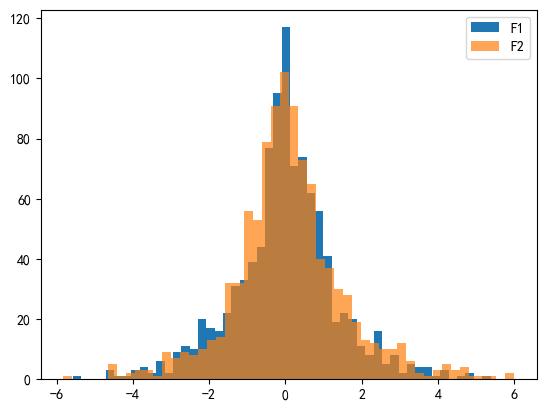

In [33]:
# 绘制F1
plt.hist([F1() for i in range(1000)], bins=50, label='F1');

# 绘制F2（看起来应该与F1相同）
plt.hist([F2() for i in range(1000)], bins=50, alpha=.7, label='F2');
plt.legend();

我们绘制出`F1`和`F3`的输出概率分布图。可以看出，`F3`的输出概率分布看起来比`F1`的更"尖"，这是因为$\epsilon$取值越大意味着隐私保护程度越低，因此输出结果远离真实结果的可能性也就越小。

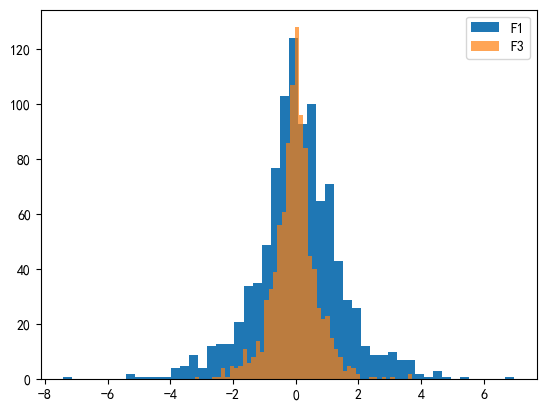

In [34]:
# 绘制F1
plt.hist([F1() for i in range(1000)], bins=50, label='F1');

# 绘制F3（看起来应该比F1更"尖"）
plt.hist([F3() for i in range(1000)], bins=50, alpha=.7, label='F3');
plt.legend();

我们再绘制出`F1`和`F_combined`的输出概率分布图。可以看出，`F_combined`的输出概率分布图更尖。这意味着`F_combined`的输出结果比`F1`的输出结果更准确，对应的$\epsilon$取值一定更大（即`F_combined`的隐私保护程度比`F1`更低）。

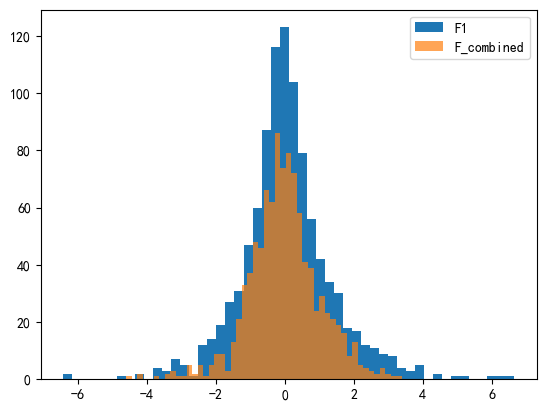

In [35]:
# 绘制F1
plt.hist([F1() for i in range(1000)], bins=50, label='F1');

# 绘制F_combined（看起来应该比F1更"尖"）
plt.hist([F_combined() for i in range(1000)], bins=50, alpha=.7, label='F_combined');
plt.legend();

那`F3`和`F_combined`呢？回想一下，这两种机制的$\epsilon$取值相等，$\epsilon$都等于2。他们的输出概率分布看起来应该也相同才对。

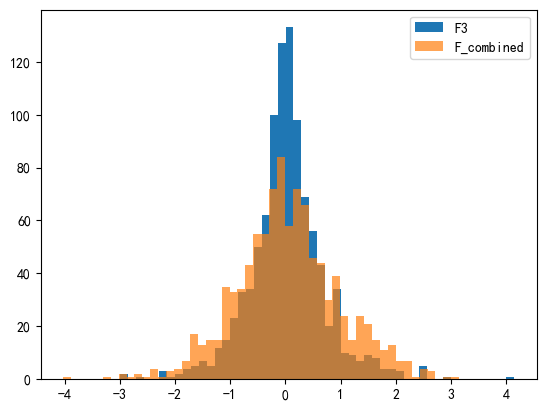

In [36]:
# 绘制F3
plt.hist([F3() for i in range(1000)], bins=50, label='F3');

# 绘制F_combined（看起来应该与F3相同）
plt.hist([F_combined() for i in range(1000)], bins=50, alpha=.7, label='F_combined');
plt.legend();

实际上，`F3`看起来更"尖"！为什么会这样呢？请记住，串行组合性给出了多次发布后总$\epsilon$的*上界*，实际发布的累积隐私消耗量可能会更低一些。这也是`F3`看起来更"尖"，而`F_combined`看起来更"平"的原因：实际隐私消耗量似乎比串行组合性给出的$\epsilon$上界要低一些。当控制总隐私消耗量时，串行组合性是一个极为有用的方法。我们后面将会通过各种不同的方式应用串行组合性。但请特别注意，串行组合性给出的隐私消耗量不一定是严格准确的，而是一个上界。

## 并行组合性

差分隐私的第二个重要性质为*并行组合性*（Parallel Composition） {cite}`mcsherry2009`。并行组合性是计算多次数据发布总隐私消耗量的第二种方法，可以看成是串行组合性的替代方法。并行组合性的基本思想是：将数据集拆分为互不相交的子数据块，在子数据块上分别应用相应的差分隐私机制。由于子数据块互不相交，每个个体的数据"仅可能"出现在一个子数据块中。因此，即使把数据集划分为$k$个子数据块，并在$k$个子数据块上分别应用相同的差分隐私机制（这意味着我们在数据集上应用了$k$次差分隐私机制），我们再每个*个体*数据上仅使用了一次差分隐私机制。数学语言描述如下：

```{prf:theorem} 并行组合
:label: parallel-composition-def
- 如果$F(x)$满足$\epsilon$-差分隐私性
- 我们将数据集$X$切分为$k$个互不相交的子数据块$x_1 \cup ... \cup x_k = X$
- 则发布所有结果$F(x_1), ..., F(x_k)$的机制满足$\epsilon$-差分隐私性
```

注意到，并行组合性给出的隐私消耗量比串行组合性要好得多。如果我们运行$k$次$F$，串行组合性告诉我们这个过程满足$k \epsilon$-差分隐私性，而并行组合性告诉我们总隐私消耗量仅为$\epsilon$。

并行组合性的数学定义与我们的直觉相匹配。如果每个个体只为数据集$X$贡献一行数据，则这行数据*仅可能*出现在$x_1, ..., x_k$的一个子数据块中。这意味着$F$只能"看到"*一次*此个体的数据。因此，将此个体的隐私消耗量设置为$\epsilon$是合理的。对于任意一个个体，$F$都只能"看到"*一次*此个体的数据，因此每个个体的隐私消耗量都等于$\epsilon$。

### 直方图

*直方图*（Histogram）是数据集的一种分析方法。直方图根据数据的某个属性将数据集划分到各个"桶"中，并统计每个桶所包含的数据行数。举个例子，直方图可以统计数据集中达到特定教育水平的人数。

In [37]:
adult = pd.read_csv("adult_with_pii.csv")
adult['Education'].value_counts().to_frame().head(5)

,count
Education,
HS-grad,10501
Some-college,7291
Bachelors,5355
Masters,1723
Assoc-voc,1383


直方图是差分隐私领域中一个非常有趣的实例，因为直方图天生满足并行组合性。直方图的每个"桶"都与数据的某个属性值对应（例如`'Education' == 'HS-grad'`）。由于单行数据不可能同时拥有*两个*属性值，因此当通过这种方式定义桶时，可以*保证*各个桶包含的数据一定是互不相交的。这样一来，直方图满足了并行组合性的应用条件，我们可以应用一个差分隐私机制发布*所有*桶中数据行数的计数结果，而总隐私消耗量仅为$\epsilon$。

In [38]:
epsilon = 1

# 虽然我们发布了多个结果，但此次数据分析的总隐私消耗量为ε = 1
f = lambda x: x + np.random.laplace(loc=0, scale=1/epsilon)
s = adult['Education'].value_counts().apply(f)
s.to_frame().head(5)

,count
Education,
HS-grad,10500.715062
Some-college,7290.923488
Bachelors,5359.539398
Masters,1723.645721
Assoc-voc,1385.622672


### 列联表

*列联表*（Contingency Table）也被称为*交叉列表*（Cross Tabulation），有时也被简称为*交叉表*（Crosstab）。可以把列联表看成一个高维直方图。列联表统计数据集中拥有多个特定属性值的数据量。在进行数据分析时，列联表通常用于展示两个变量之间的关系。例如，我们可能希望看到基于教育水平和性别这两种属性的联合统计结果：

In [39]:
pd.crosstab(adult['Education'], adult['Sex']).head(5)

Sex,Female,Male
Education,,
10th,295,638
11th,432,743
12th,144,289
1st-4th,46,122
5th-6th,84,249


与我们前面已经介绍的直方图一样，数据集中的每个个体同样仅参与了列联表中的*一次*计数统计。对于任何可以用于构建列联表的属性，任何单行数据都不可能同时拥有此属性的多个属性值。

In [40]:
ct = pd.crosstab(adult['Education'], adult['Sex'])
f = lambda x: x + np.random.laplace(loc=0, scale=1/epsilon)
ct.applymap(f).head(5)

C:\Users\83442\AppData\Local\Temp\ipykernel_15492\797734013.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ct.applymap(f).head(5)


Sex,Female,Male
Education,,
10th,292.945459,637.874069
11th,432.145927,742.704398
12th,145.869181,288.614686
1st-4th,45.427473,121.105522
5th-6th,83.877773,251.158374


也可以为包含2个以上的属性生成相应的列联表。但我们要考虑一下，每次我们增加一个属性后会发生什么：每个计数结果都会变得更小。直观上看，当我们将数据集分割成更多的数据块时，每个数据块包含的数据行数会变得更少，因此所有的计数结果都会变得更小。

真实计数值的缩小将对差分隐私计数结果的准确性造成巨大的影响。我们可以从信号和噪声的角度来做个类比。较大的计数结果表示一个强*信号*，不太可能被一个相对较弱的噪声（例如我们前面增加的噪声）所淹没。此时，即使我们增加了噪声，得到的计数结果也有较好的可用性。反之，较小的计数结果表示一个弱*信号*，信号强度甚至可能接近噪声量。此时，如果再增加噪声，我们就无法从结果中获得任何有用的信息了。

因此，虽然并行组合性看起来为我们提供了部分"免费"的隐私保护能力（在相同隐私消耗量下可以发布更多的结果），但事实并非如此。并行组合性只是沿着不同的方向在准确性和隐私性之间进行权衡。当我们将数据集划分成更多的数据块并发布更多的结果时，每个结果的信号量也会变弱，结果的准确性也会变得更低。

## 后处理性

我们在本章要讨论的第三个差分隐私性质称为*后处理性*（Post-processing）。此性质的基本思想非常简单：不可能通过某种方式对差分隐私保护下的数据进行后处理，来降低差分隐私的隐私保护程度。此性质的数学语言描述为：

```{prf:theorem} 后处理性
:label: post-processing-def
- 如果$F(X)$满足$\epsilon$-差分隐私
- 则对于任意（确定或随机）函数$g$，$g(F(X))$也满足$\epsilon$-差分隐私。
```

后处理性意味着在差分隐私机制的输出结果上执行任意计算也总是安全的。任意计算均不会降低差分隐私机制所提供的隐私保护程度。特别地，我们甚至可以对计算结果进行后处理，以降低噪声量、改善输出结果（例如，对于不应该返回负数的问询，将负数回复结果替换为零）。事实上，许多复杂的差分隐私算法都会利用后处理性来降低噪声，提高输出结果的准确性。

后处理性的另一个含义是，差分隐私可以抵抗基于辅助信息的隐私攻击方法。例如，函数$g$可能包含关于数据集元素的辅助信息，$g$期望利用该信息实施关联攻击。后处理性告诉我们，无论$g$中包含何种辅助信息，此攻击的效果都会被隐私参数$\epsilon$所约束。

```{admonition} Summary
- 串行组合限制了在相同输入数据上发布多个差分隐私机制结果的总隐私成本。
- 并行组合基于将数据集拆分为不相交的块，并分别在每个块上运行差分隐私机制的想法。
- 后处理属性意味着对差分隐私机制的输出进行任意计算始终是安全的。
```